In [60]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import librosa
from librosa import display
import librosa.display
from fractions import Fraction
from iteration_utilities import deepflatten #flatten nested lists
import string

import pretty_midi

import fluidsynth
import soundfile as sf
import music21
from music21 import *
import itertools
import random
import mchmm #for Markov models

import pysndfx #sound processing

import nltk #for NLP

#Just a helper function
def flatten_list(hierarchical_list):
    #Flatten a list of lists
    return [x for sublist in hierarchical_list for x in sublist]

This notebook exemplifies a few modalities of rhythm generation. We start by simply assembling consecutive durations in an arbitrary way (1). Then, we fix the probabilities for transitioning from one duration to the next, building a Markov model (2). Rather than fixing the transition probabilities ourselves, we can train a Markov model to learn the transition probabilities from some corpus, and then using these transition probabilities to generate new rhythms (3). Finally, we implement a Context Free Grammar for generating rhythms hierarchically (4).

Before engaging with the main topics, it will be useful to define some helper functions to save some time.

# Helper functions

First, here is a shortcut for playback, which we have already seen in last week's ntoebook:

In [3]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

Now, we use the tools provided by music21 in order to create percussion sounds and embedding them in streams.
First, let us create a note object of given duration. 

We express durations in whole-note units, so that quarter-notes have duration 1/4, eigth-notes have duration 1/8 etc. You can easily change the duration unit by assigning a new value to the UNIT variable.

Since we are dealing with rhythm, we don't really care about the pitch of the notes, so we assign a default value (C4). When calling the percussion_hit function, you can either stick to the default pitch (just omit the pitch parameter) or you can specify a new value for the pitch parameter.

In [ ]:
#GLOBAL CONSTANTS
UNIT = 1 #We express duration as fractions of a whole note. Use UNIT = 1/4 to express durations as fractions of quarter-notes

def percussion_hit(duration, pitch = "C4"):
    #Create Note object for percussion hits (default pitch is C4)
    return Note(pitch, quarterLength = duration*(4*UNIT))

So, a percussion_hit of duration 1 (whole-note) spans 4 quarter-notes:

In [7]:
percussion_hit(1).quarterLength

4.0

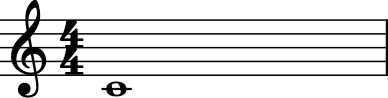

In [12]:
percussion_hit(1).show()

Now, we create a container object (a Stream or a Measure) for our percussion_hits. By default, no time signature is specified, so that a single measure of unspecified capacity is generated. If you do specify a time signature when calling the create_percussion function, a stream with the given time signature is created instead.

In [9]:
def create_percussion(time_sig = None):
    #Initialize a percussion stream with Woodblock timbre
    #If time signature is None, no measure splits
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.Woodblock()) #assign woosblock timbre
    return drumPart

We can now embed a percussion_hit in a stream. To simplify the process, we define new functions that append a percussion_hit of given duration to a percussion stream:

In [31]:
def append_event(duration, original_stream, rest = False):
    #Returns a new_stream obtained by appending a rhythmical event or a rest of given duration to the original_stream
    new_stream = original_stream
    if rest:
        new_stream.append(note.Rest(quarterLength = duration*(4*UNIT)))
    else:
        new_stream.append(percussion_hit(duration))
    return new_stream


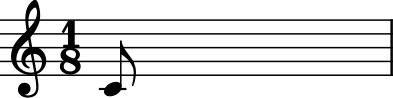

In [32]:
m = create_percussion()
append_event(1/8, m).show()

# 1. Additive rhythm generation

Now, we are ready to produce rhythms! 

By running the following cell with start_new set to True, you initialise an empty rhythmic stream and fill it with one note of duration new_duration. If you set start_new to False, you can keep adding new notes to the stream. Every time you append a new note, you can decide its duration by assigining a value to the variable new_duration. You can also insert rests, by changing the truth value of the is_rest variable.

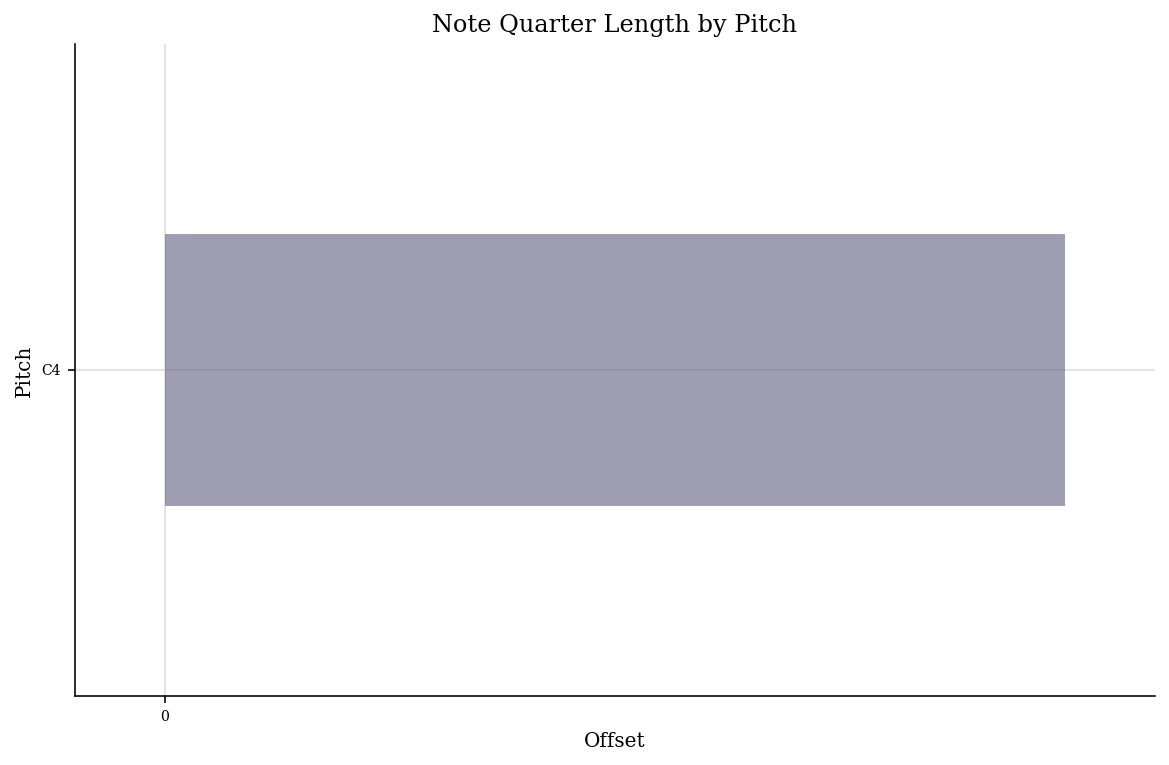

In [38]:
start_new = True

#What duration do you want to add to the rhythm?
new_duration = 3/8
is_rest = False

if start_new:
    #If start_new is true, initialise a new rhythmic stream
    initial = create_percussion()

updated = initial
updated = append_event(new_duration, updated, rest = is_rest)

    
updated.plot()
play(updated)

### Rhythm from list of durations

Instead of adding one percussion_hit at a time, we can specify a whole sequence of durations at once: 

In [45]:
def rhythm_from_sequence(durations, time_sig = None):
    #Generate rhythmic stream from a list of durations. Rests are indicated by specifying a duration as a string
    rhythm = create_percussion(time_sig = time_sig)
    for dur in durations:
        is_rest = False
        if type(dur) == str:
            #if duration is given as a string, interpret and rest and turn string into a numerical value
            is_rest = True
            dur = Fraction(dur)
            
        rhythm = append_event(dur, rhythm, rest = is_rest) 
    return rhythm


Let's play and show a sequence of arbitrary durations:

In [50]:
duration_sequence = [1/4, 1/8, 1/8, 1/4/3, 2/4/3,  '1/8' ,  1/4]    
rhythm = rhythm_from_sequence(duration_sequence)
play(rhythm)    

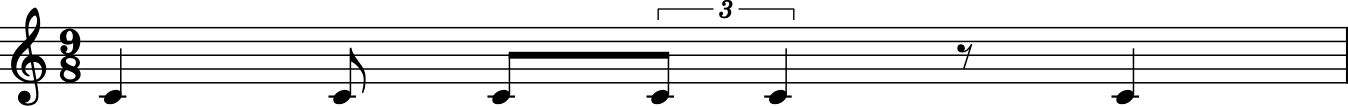

In [51]:
rhythm.show()

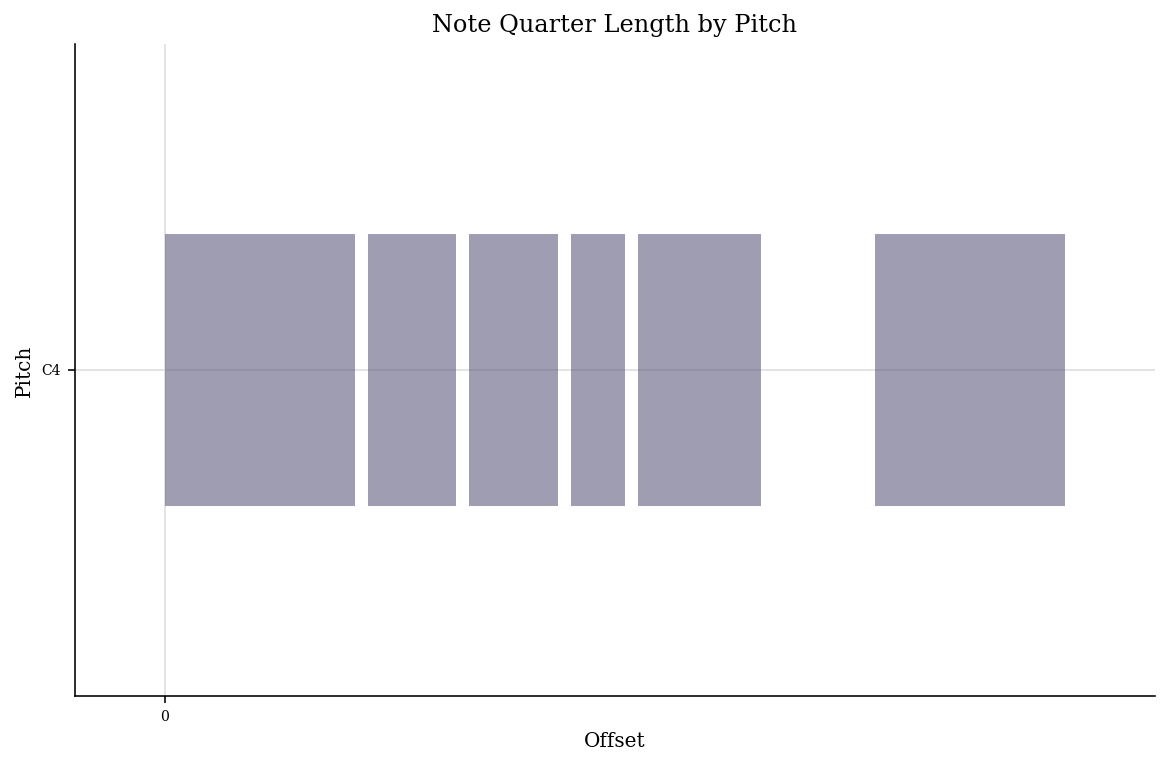

In [52]:
rhythm.plot()

# 2. Markovian generation

Music is about *organising* sounds in time. As a consequence, we want our rhythms to be governed by some generative principle. A possible generative principle is to specify the probability for any new duration in a sequence given the preceding duration(s). Here is an example of a markovian rhythm.

First, we decide what our "alphabet" of durations is going to be. In this case, just as an example, we start with two elementary durations: the sixteenth-note (duration 1/16, or one quarter of a quarter-note) and the triplet of eigth-notes (duration 1/12, or one third of a quarter-note). 

In [ ]:
ELEMENTARY_DURATIONS = [1/4/4 , 1/4/3] #Our set of elementary durations comprises a binary (a sixtheenth-note) and a ternary (triplet) duration

We generate other durations by combining up to MAX_COMPONENTS elementary durations:

In [58]:
MAX_COMPONENTS = 4

def generate_duration(elementary_durations = ELEMENTARY_DURATIONS, max_comp = MAX_COMPONENTS):
    #Randomly generate a legal duration by assembling up to max_comp components drawn from the elementary durations
    
    dur = random.choice(elementary_durations) #initialize by picking an elemenary duration at random
    
    for i in range(max_comp-1): #iterate max_comp times
        if random.random() > 0.5: #randomly determine whether to add a component or not
            dur += random.choice(elementary_durations) #randomly select a binary or ternary component
            
    return dur

As a consequence, the alphabet of all possible durations is:

In [61]:
def all_durations(elementary_durations = ELEMENTARY_DURATIONS, max_comp = MAX_COMPONENTS):
    #Compute all possible legal durations
    
    compute_durations = [list(itertools.combinations_with_replacement(elementary_durations, i)) for i in range(1,max_comp+1)]
    flatten_durations = flatten_list(compute_durations)
    return list(map(sum, flatten_durations))

all_durations()

[0.0625,
 0.08333333333333333,
 0.125,
 0.14583333333333331,
 0.16666666666666666,
 0.1875,
 0.20833333333333331,
 0.22916666666666663,
 0.25,
 0.25,
 0.2708333333333333,
 0.29166666666666663,
 0.31249999999999994,
 0.3333333333333333]

For each possible duration x, we need to specify the probability the duration x may follow duration y in a rhythmic sequence. As an example, we adopt here the following simple criterion. We divide our alphabet of durations in two classes: the durations that only comprise binary elementary components and the durations that also comprise ternary elementary components. We then decide that a duration is 4 times more likely to be followed by a duration from the same class than by a duration from the other class.

In [63]:
def transition_probs(last_dur, new_dur):
    #Transition probability of new_dur given the previous duration last_dur
    #Here, we have two categories of rhythmic values (pure binary vs. ternary/hybrid). 
    #We make it 4 times more likely for new_dur to fall in the same category than to switch
    if int(last_dur*4) == last_dur*4:
        if int(new_dur*4) == new_dur*4:
            return 0.8
        else:
            return 0.2
    else:
        if int(new_dur*4) == new_dur*4:
            return 0.2
        else:
            return 0.8

All that is left to do is to generate stochastically a rhythmic sequence by drawing each new duration from our alphabet of durations based on a probability distribution that depends on the immediately preceding duration. 

In [68]:
def new_duration(last_dur, elementary_durations = ELEMENTARY_DURATIONS, max_components = MAX_COMPONENTS):
    #Generate new duration given previous duration last_dur
    all_dur = all_durations(elementary_durations, max_components)
    
    return random.choices(all_dur, [transition_probs(last_dur, x) for x in all_dur])[0] #draw from all_dur according to a probability distribution given by transition_probs
    
    
def generate_rhythm(l, current = None):
    #Generate recursively a sequence of durations comprising l events
    if current == None:
        #initialise with a random legal duration
        dur_sequence = [generate_duration()]
    else:
        dur_sequence = current
        
    if l>1:
        #Call the function generate_rhythm recursively to generate all durations from position 2 to position l in the sequence
        new = new_duration(dur_sequence[-1])
        dur_sequence += [new]
        return generate_rhythm(l-1, current = dur_sequence)
    else:
        return dur_sequence

In [70]:
play(rhythm_from_sequence(generate_rhythm(20)))

# 3. Train Markov chain

Now, instead of specifying the transition probabilities arbitrarily, we can infer them from some other stochastic process: for example, word lengths in a literary text. 

`NLTK`, a python library for natural language processing, provides us with the tools to do it. First, let's take the text of Carrol's Alice in Wonderland from `nltk`'s corpus, extract the words as a list, and filter out the punctuation. Finally, we map each word into its length. We obtain a list of numbers.

In [72]:
alice_in_wonderland = nltk.corpus.gutenberg.words('carroll-alice.txt') #import word list from Alice in Wonderland
ALICE = list(filter(lambda word: np.product([character not in string.punctuation for character in word ]), alice_in_wonderland)) # filter out punctuation
ALICE_length = list(map(len, ALICE)) # map each word into its length

With the `mchmm` package we can now train a markov chain on the list of word lengths: e.g., how likely is it for a word of length 3 to follow a ford of length 1?

In [73]:
#Train Markov model on the sequence of word lengths
ALICE_markov = mchmm.MarkovChain().from_data(ALICE_length)

We can show the matrix of obserbed transition counts from a word of length x to a word of length y as a `pandas` DataFrame:

In [74]:
#Showing the transition (frequency) matrix
pd.DataFrame(ALICE_markov.observed_matrix, index = ALICE_markov.states, columns = ALICE_markov.states, dtype = int)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,105,148,274,448,273,238,122,39,30,16,4,5,0,0
2,331,560,1396,935,484,265,235,87,72,29,9,7,3,0
3,392,766,1469,1759,1095,616,465,264,126,47,51,9,3,2
4,426,1113,1639,1072,591,356,303,135,80,39,19,4,4,1
5,219,649,949,611,327,230,194,85,45,21,7,2,0,1
6,101,442,525,373,216,97,96,45,41,10,4,1,1,0
7,79,397,415,282,160,74,75,41,31,9,4,4,0,0
8,20,166,208,140,85,32,42,13,7,5,4,1,0,0
9,11,99,106,97,63,26,21,9,9,3,3,0,0,0
10,8,46,38,43,20,9,10,3,3,0,1,0,0,0


Now, we can generate a new sequence of integers (word lengths) with the markov model trained on Carrol's text. The `simulate` method of a `mchmm.MarkovChain()` object returns a list of *states* (i.e., actual word lengths) and the list of their *ID*s (i.e., the ordinal position of each state among the possible wordlengths that have been found in Carrol's text). 

In [78]:
#Simulate sequence of durations from ALICE_markov
LENGTH_OF_SEQUENCE = 12 #number of events to generate

#Markovian generation, starting with word length 3 (arbitrary).
ids, states = ALICE_markov.simulate(LENGTH_OF_SEQUENCE, start=3, seed=np.random.randint(0, LENGTH_OF_SEQUENCE, LENGTH_OF_SEQUENCE))

We can now play the resulting sequence. First, we need to decide a scaling factor to turn integers into durations (here, we opt to equate a letter to a sixteenth-note).

In [77]:
play(rhythm_from_sequence(states*1/16)) #With scaling factor 1/16

# Hierarchical generation of rhythm

## Rhythmic objects

In [48]:
class rhythmic_category:
    def __init__(self, upbeat, body, tail):
        
        #Parameters
        self.upbeat = upbeat
        self.body = body
        self.tail = tail
        self.parameters = [upbeat, body, tail]
        
    #Rule applications
    def split(self, ratio = 1/2, right_child_upbeat = 0):
        #SPLIT operation on parent metrical category, based on ratio = left_child_body/parent.body. 
        #An upbeat for the right child can be specified.
        left_child_body = self.body*ratio
        right_child_body = self.body-left_child_body
    
        left_child_cat = rhythmic_category(self.upbeat, left_child_body, - right_child_upbeat)
        right_child_cat = rhythmic_category(right_child_upbeat, right_child_body, self.tail)
    
        return list(deepflatten([left_child_cat.timesteal(), right_child_cat.timesteal()]))
    
    def prepare(self):
        #UPBEAT rule (simplified, no upbeat of upbeat)
        if self.upbeat > 0:
            left_child_cat = rhythmic_category(0, self.upbeat, 0)
            right_child_cat = rhythmic_category(0, self.body, self.tail)
    
            return list(deepflatten([left_child_cat.timesteal(),  right_child_cat.timesteal()]))
        else:
            return [self]
        
    def e_shift(self):
        #ANTICIPATE rule
        return [rhythmic_category(0, self.body, self.upbeat+self.tail)]
    
    def l_shift(self):
        #DELAY rule
        return [rhythmic_category(self.upbeat + self.tail, self.body, 0)]
    
    def timesteal(self):
        #TIMESTEALING. We apply it automatically to reduce timestolen rhythmic values as soon as they are generated
        new_upbeat = self.upbeat
        new_tail = self.tail
        timestolen_body = self.body
        if self.upbeat < 0:
            new_upbeat = 0
            timestolen_body += self.upbeat
        if self.tail < 0:
            new_tail = 0
            timestolen_body += self.tail
        return [rhythmic_category(new_upbeat, timestolen_body, new_tail)]
    
    def attach_tail(self):
        #Attach tail to body, to be used if tail > 0
        return [rhythmic_category(self.upbeat, self.body+self.tail, 0)]

    
    def get_terminals(self):
    #Recursively get terminal durations from metrical categories. Can accept 
    #If there is negative head or tail, interpret as timestealing. If there is positive head, interpret as preparation. If there is positive tail, interpret as a time-thief.
    
        if (self.upbeat == 0) and (self.tail == 0):
            return [self.body]
        elif (self.upbeat < 0) | (self.tail < 0):
            return  list(deepflatten([x.get_terminals() for x in self.timesteal()]))
        elif self.tail > 0:
            return  list(deepflatten([x.get_terminals() for x in self.attach_tail()]))
        elif self.upbeat > 0:
            return list(deepflatten([x.get_terminals() for x in self.prepare()]))
    
        
        

# Generation

In [52]:
def rule(rule_type, p1 = None, p2 = None):
    #Returns dictionary specifying a rule with its parameters
    
    rule_def = {'type': rule_type}
    
    if p1 != None:
        rule_def['p1'] = p1
    if p2 != None:
        rule_def['p2'] = p2
    
    return rule_def
    

def generate_hierarchical_rhythm(tree, starting_symbol, preterminal_string = []):
    #Recursively generate rhythm from a hierarchy of rule applications
    
    if len(tree) == 0:
        return preterminal_string + [starting_symbol]
    else:
        rule = tree[0]
        if rule['type'] == 'split':
            children = starting_symbol.split(ratio = rule['p1'], right_child_upbeat = rule['p2'])
        elif rule['type'] == 'prepare':
            children = starting_symbol.prepare()
        elif rule['type'] == 'anticipate':
            children = starting_symbol.e_shift()
        elif rule['type'] == 'delay':
            children = starting_symbol.l_shift()
            
               
        for child_n in range(len(children)):
            preterminal_string = generate_hierarchical_rhythm(tree[child_n+1], children[child_n], preterminal_string = preterminal_string)
                
    
        return preterminal_string
    

def get_terminal_durations(rhythmic_categories):
    #Turns list of pre-terminal categories in list of terminal durations
    return list(deepflatten([x.get_terminals() for x in rhythmic_categories]))
    

In [53]:
#Define start symbol
S = rhythmic_category(0, 2, 0)

#Define derivation: each node is in the form [rule('ruletype', parameter1, parameter2), [child_node1], [child_node2]]
k = [rule('split', 1/2, 0), [rule('split', 1/2, 0), [rule('split', 1/2, 1/16), [], []], []], [rule('split', 1/2, 1/8), [], [rule('anticipate'), []]]]

generated_rhythm = rhythm_from_sequence(get_terminal_durations(generate_hierarchical_rhythm(k, S, preterminal_string = [])), time_sig = '4/4')

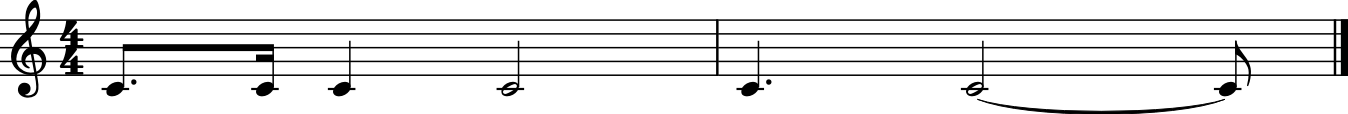

In [56]:
generated_rhythm.show()

In [57]:
play(generated_rhythm)